# Network Analysis for Information Retrieval - Part 2

Elyes KHALFALLAH & Mohammed Ali EL ADLOUNI

16/03/2025

---

---


## Exercice 4 : Structurer le corpus


In [1]:
# Useful libraries
import numpy as np
import pandas as pd
from fonctions import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


### 4.1. Espace des mots avec algorithme de clustering k-means


In [2]:
# # load X_tf.npy and X_tf_idf.npy
# X_tf = np.load('X_tf.npy', allow_pickle=True)
# X_tfidf = np.load('X_tfidf.npy', allow_pickle=True)

# # convert X_tf and X_tfidf to dense matrices
# X_tf = X_tf.item()
# X_tfidf = X_tfidf.item()

# # print shape oshape of the matrix X_tfidf is ()f X_tfidf
# print(f"shape of the matrix X_tfidf is {X_tfidf.shape}")


In [3]:
# Nous allons maintenant construire la matrice Documents x Termes en adoprant le schéma de pondération TF-IDF

# Load the data
data_text = pd.read_csv("data_text.csv")
print(data_text.shape, "\n")

# Print each class and the number of samples in each class
print(data_text["class"].value_counts())


(40596, 10) 

class
1    10099
2     7388
5     5223
8     4812
7     4713
6     3570
4     2500
3     2291
Name: count, dtype: int64


In [4]:
# When removing stopwords and most common words, some rows may become empty. We need to remove them.
data_text = data_text.dropna(subset=["text"])
print(data_text.shape)


(40595, 10)


In [5]:
# Define the vectorizer
tf_vectorizer = TfidfVectorizer(use_idf=False, stop_words="english")

# Fit and transform the vectorizer on the 'text' column
X_tf = tf_vectorizer.fit_transform(data_text["text"])

# Show the shape of the resulting matrix
X_tf.shape


(40595, 55306)

In [6]:
# Step 1: Apply KMeans Clustering as well as other methods for comparison
# Method 1 : KMeans Clustering
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X_tf)

# # Method 2 : t-SNE (TOO LONG)
# # Apply t-SNE for visualization
# tsne = TSNE(n_components=2, random_state=42)
# X_tf_tsne = tsne.fit_transform(X_tf.toarray())

# Method 3 : PCA
# Apply PCA for visualization
pca = PCA(n_components=8)
X_tf_pca = pca.fit_transform(X_tf.toarray())

# # Method 4 : TruncatedSVD
# # Apply TruncatedSVD for visualization
# svd = TruncatedSVD(n_components=8, random_state=42)
# X_tf_svd = svd.fit_transform(X_tf)


KMeans:
0    17878
5     8383
1     3013
4     2823
3     2641
7     2351
2     2073
6     1433
Name: count, dtype: int64 



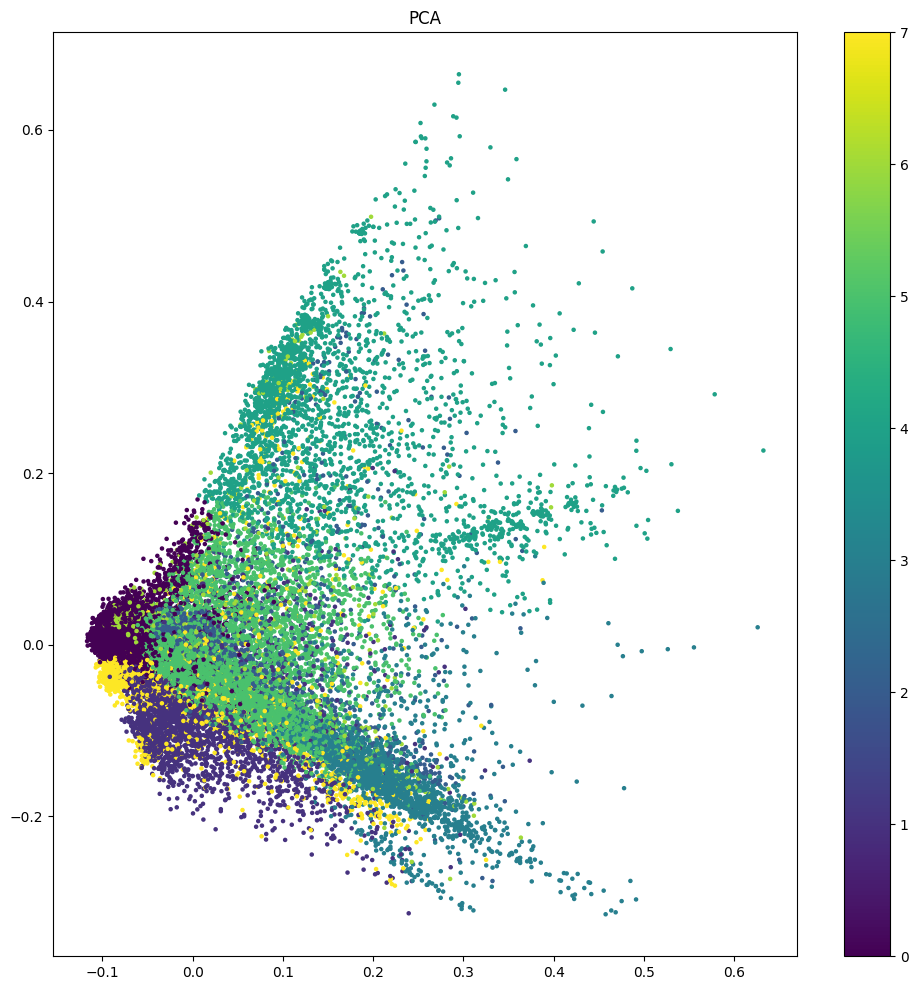

In [7]:
print("KMeans:")
print(pd.Series(labels).value_counts(), "\n")

# Plot only PCA
plt.figure(figsize=(12, 12))
plt.scatter(X_tf_pca[:, 0], X_tf_pca[:, 1], c=labels, cmap="viridis", s=5)
plt.colorbar()
plt.title("PCA")

plt.show()


In [8]:
# Step 2: Reduce to 2D for visualization
# Normalize before PCA
scaler = StandardScaler(with_mean=False)  # Set to False for sparse data
X_tf = scaler.fit_transform(X_tf)

# Use PCA
pca = PCA(n_components=2)
X_tf_pca = pca.fit_transform(X_tf.toarray())


# Use TruncatedSVD instead of PCA
svd = TruncatedSVD(n_components=2, random_state=42)
X_tf_pca = svd.fit_transform(X_tf)

# Check explained variance to see if one component dominates
print("Explained variance ratio:", svd.explained_variance_ratio_)


Explained variance ratio: [0.00518371 0.00157177]


In [9]:
print(np.unique(labels))

# print how percentage of each unique values in variable "labels"
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)


[0 1 2 3 4 5 6 7]
[[    0 17878]
 [    1  3013]
 [    2  2073]
 [    3  2641]
 [    4  2823]
 [    5  8383]
 [    6  1433]
 [    7  2351]]


In [10]:
# Use t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tf_tsne = tsne.fit_transform(X_tf[:1000].toarray())


### Apply Latent Dirichlet Allocation (LDA)


C:\Users\elyes\AppData\Local\Temp\ipykernel_28272\2331822676.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 8)  # "tab10" provides 10 distinct colors, limiting to 8


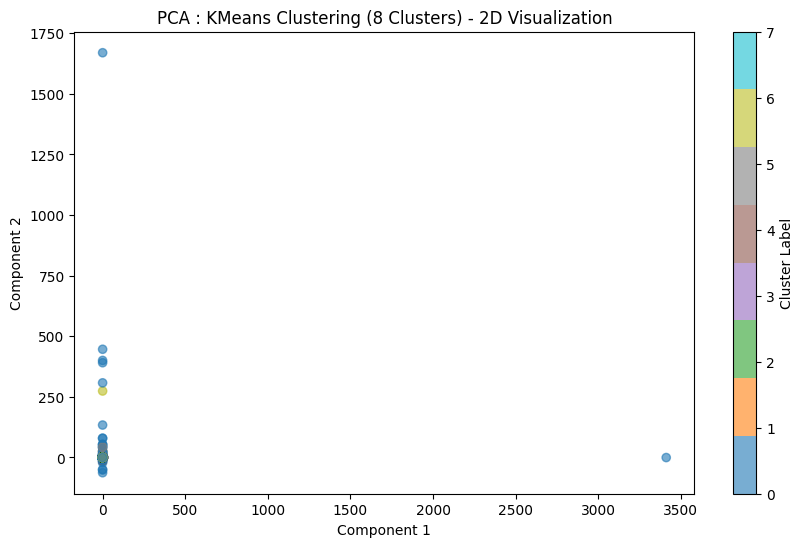

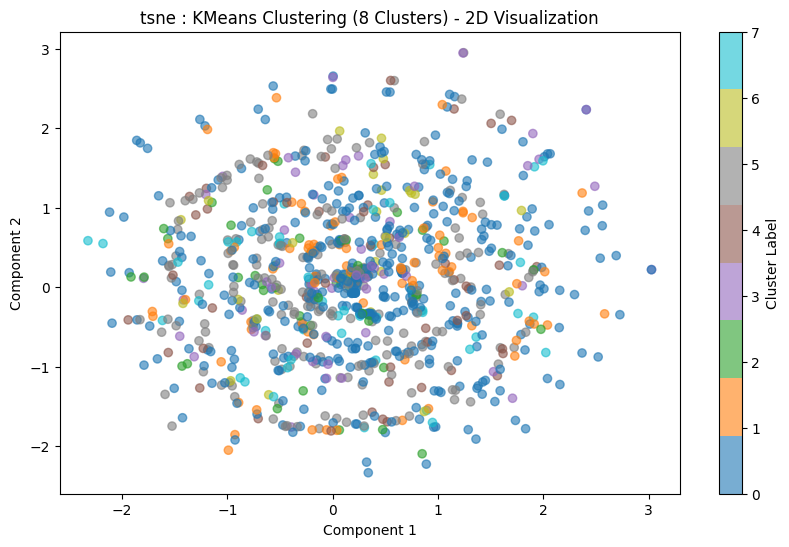

In [11]:
# Step 3: Plot the clusters

cmap = plt.cm.get_cmap("tab10", 8)  # "tab10" provides 10 distinct colors, limiting to 8

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tf_pca[:, 0], X_tf_pca[:, 1], c=labels, cmap=cmap, alpha=0.6)
plt.colorbar(scatter, label="Cluster Label")
plt.title("PCA : KMeans Clustering (8 Clusters) - 2D Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_tf_tsne[:1000, 0], X_tf_tsne[:1000, 1], c=labels[:1000], cmap=cmap, alpha=0.6
)
plt.colorbar(scatter, label="Cluster Label")
plt.title("tsne : KMeans Clustering (8 Clusters) - 2D Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [12]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 8
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
X_topics = lda_model.fit_transform(X_tf)


In [13]:
X_topics.shape


(40595, 8)

In [14]:
X_topics[0]


array([3.24332645e-04, 3.24428610e-04, 9.97729273e-01, 3.24433524e-04,
       3.24492201e-04, 3.24321633e-04, 3.24365455e-04, 3.24353297e-04])

## Exercice 5 : Visualisation du corpus


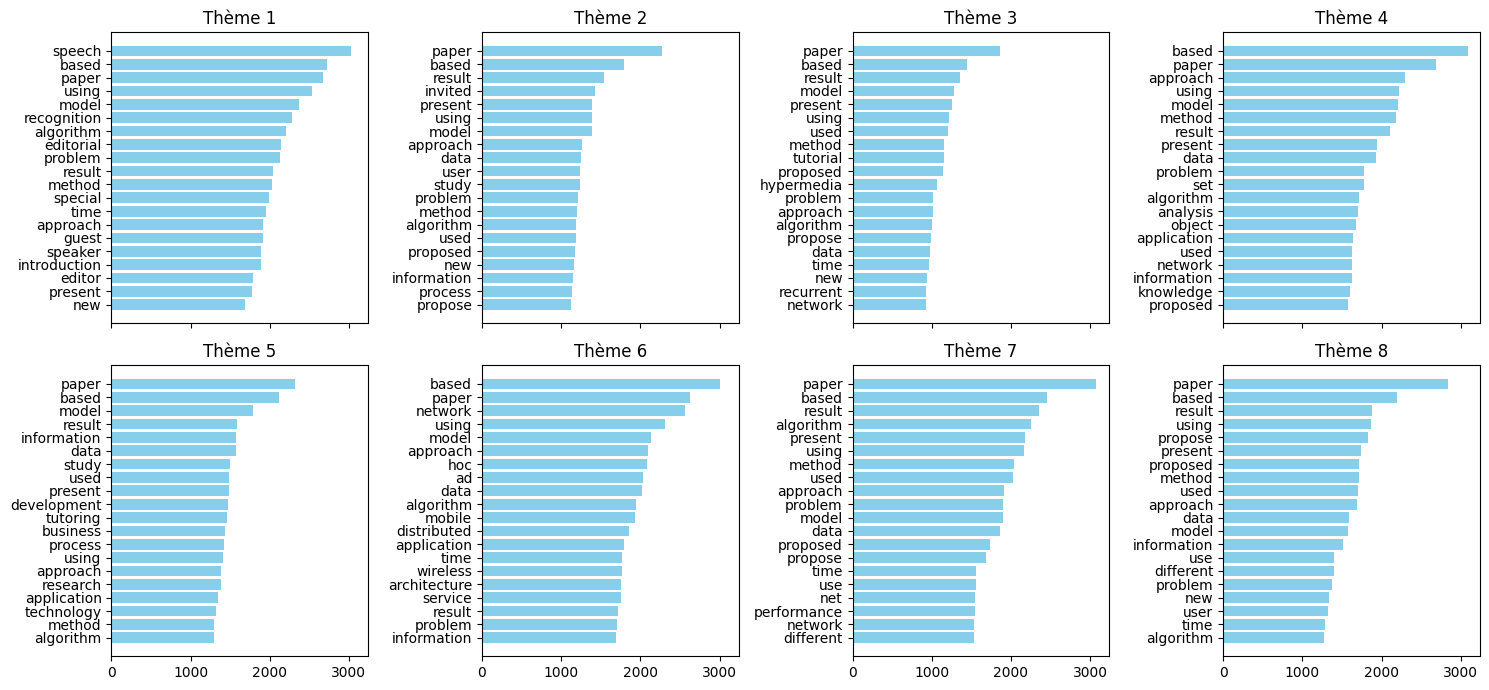

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer


# Récupérer le vocabulaire
feature_names = tf_vectorizer.get_feature_names_out()

# Nombre de mots à afficher par thème
top_n_words = 20

# Afficher les mots les plus importants de chaque thème
fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharex=True)
axes = axes.flatten()

for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[
        -top_n_words:
    ]  # Indices des mots les plus importants
    top_words = [feature_names[i] for i in top_words_idx]  # Convertir indices en mots
    top_values = topic[top_words_idx]  # Poids des mots

    # Tracer le bar plot
    ax = axes[topic_idx]
    ax.barh(top_words, top_values, color="skyblue")
    ax.set_title(f"Thème {topic_idx+1}")

plt.tight_layout()
plt.show()


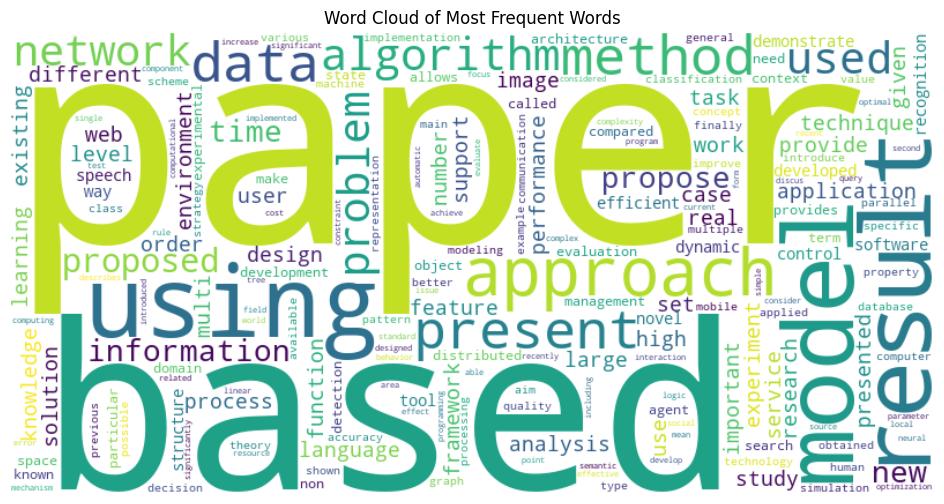

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Convert sparse matrix (X_tf) to an array of word counts
word_counts = X_tf.toarray().sum(axis=0)

# Map word counts to feature names (words)
word_freq = dict(zip(tf_vectorizer.get_feature_names_out(), word_counts))

# Generate and plot the word cloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud of Most Frequent Words")
plt.show()


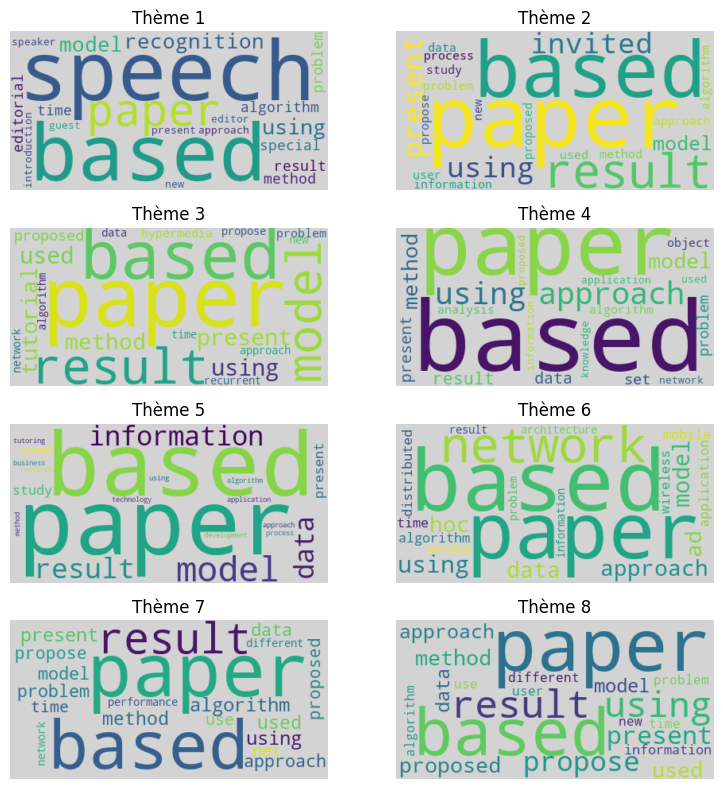

In [17]:
# --- Word Clouds for Each Topic ---
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for topic_idx, topic in enumerate(lda_model.components_):
    # Get word frequencies for this topic
    top_words_idx = topic.argsort()[-top_n_words:]  # Top word indices
    top_words = [feature_names[i] for i in top_words_idx]  # Convert to actual words
    top_values = topic[top_words_idx]  # Weights

    # Create a dictionary of word frequencies
    word_freq = {word: value for word, value in zip(top_words, top_values)}

    # Generate word cloud
    wordcloud = WordCloud(
        width=400, height=200, background_color="lightgray"
    ).generate_from_frequencies(word_freq)

    # Display word cloud
    ax = axes[topic_idx]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Thème {topic_idx+1}")

plt.tight_layout()
plt.show()


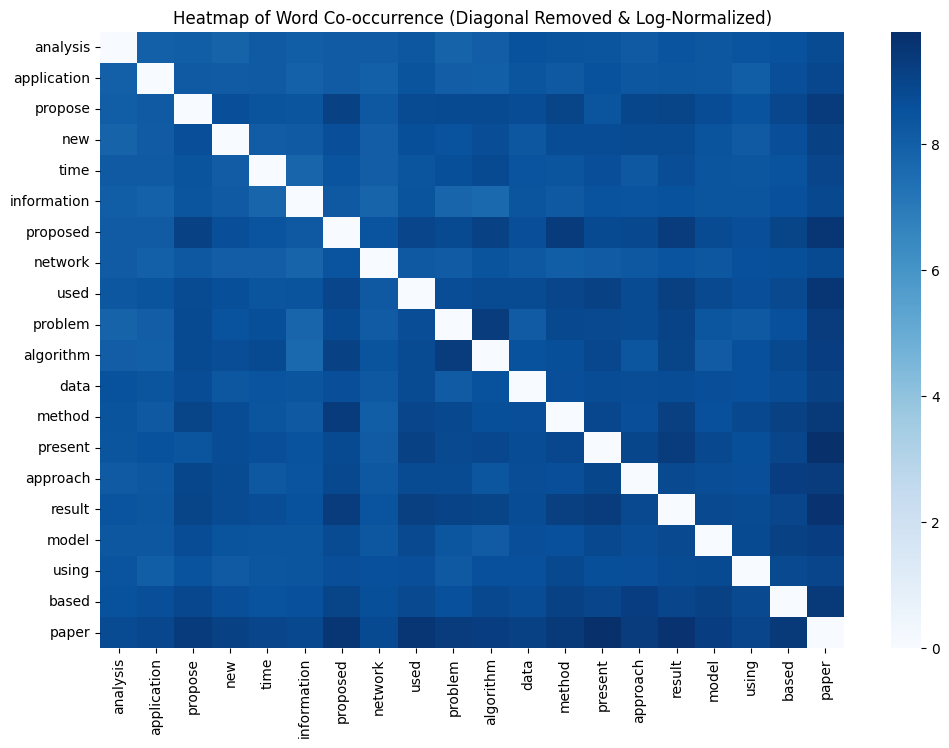

In [18]:
# Convert the co-occurrence matrix to a DataFrame
words = tf_vectorizer.get_feature_names_out()
co_occurrence_matrix = (X_tf.T @ X_tf).toarray()

# Convert to DataFrame
co_df = pd.DataFrame(co_occurrence_matrix, index=words, columns=words)

# Remove self-co-occurrences (set diagonal to 0)
np.fill_diagonal(co_df.values, 0)

# Normalize with log transformation to make small values visible
co_df_log = np.log1p(co_df)  # log1p(x) = log(1 + x) (avoids log(0) issues)

# Select top 20 words by frequency
top_n = 20
word_frequencies = X_tf.toarray().sum(axis=0)
top_words_idx = np.argsort(word_frequencies)[-top_n:]
co_df_top = co_df_log.iloc[top_words_idx, top_words_idx]

# Plot the improved heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(co_df_top, cmap="Blues", annot=False, xticklabels=True, yticklabels=True)
plt.title("Heatmap of Word Co-occurrence (Diagonal Removed & Log-Normalized)")
plt.show()
